In [12]:
# DRO analysis

In [14]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pickle, gzip, os
from dro import *

GPU=False


In [18]:
# Import DRO results
out = load_out("/Users/chrismader/Python/SLDS/Output/dro_run.pkl.gz")

In [20]:
# Print results
results = {
    "MVO":          pd.DataFrame([out["MVO"]["summary"]]),
    "DRO (Static)": pd.DataFrame([out["PartA"]["summary"]]),
    "Regime-DRO":   pd.DataFrame([out["PartB"]["summary"]]),
}

tbl = oos_summary(results, model_order=["MVO","DRO (Static)","Regime-DRO"])
display(tbl.loc[["mu_ann","sigma_ann","sharpe_ann","vol_breach","max_drawdown"]])

,MVO,DRO (Static),Regime-DRO
mu_ann,0.3012,0.3021,NaN
sigma_ann,0.3426,0.3426,237.6533
sharpe_ann,0.8259,0.8277,1.1622
vol_breach,0.0426,0.0426,237.3533
max_drawdown,-0.5868,-0.5868,NaN


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


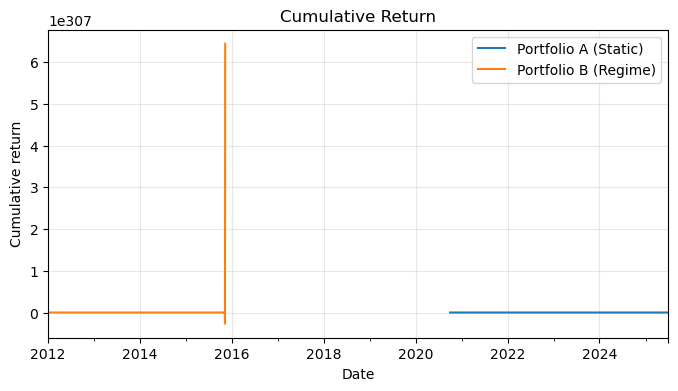

In [22]:
# Plot Portfolio A vs Portfolio B

# pull series safely
sA = pd.Series(out["series"].get("PartA_daily", pd.Series(dtype=float))).sort_index()
sB = pd.Series(out["series"].get("PartB_daily", pd.Series(dtype=float))).sort_index()

if sA.empty or sB.empty:
    raise ValueError("Missing series in `out['series']`. Expected 'PartA_daily' and 'PartB_daily'.")

# cumulative returns
cumA = (1 + sA).cumprod() - 1
cumB = (1 + sB).cumprod() - 1

# --- cumulative on one chart ---
fig, ax = plt.subplots(figsize=(8, 4))
cumA.plot(ax=ax, label="Portfolio A (Static)")
cumB.plot(ax=ax, label="Portfolio B (Regime)")
ax.set_title("Cumulative Return")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return")
ax.grid(True, alpha=0.3)
ax.legend()

In [24]:
# Show deltas got tighter

summA = pd.Series(out["PartA"]["summary"])
summB = pd.Series(out["PartB"]["summary"])

# pull delta and per-segment deltas
delta_A = float(summA.get("delta", float("nan")))
delta_ks = [summB[k] for k in summB.index if str(k).startswith("delta_k")]
display(pd.DataFrame({
    "Static δ (Part A)": [delta_A],
    "Regime δ_k (Part B)": [pd.Series(delta_ks, dtype=float).describe()[["count","mean","min","25%","50%","75%","max"]].to_dict()]
}))


,Static δ (Part A),Regime δ_k (Part B)
0,NaN,"{'count': 446.0, 'mean': 0.0018515380316184026..."


In [26]:
# Compare OOS performance

from dro import oos_summary

results = {
    "DRO (Static)": pd.DataFrame([out["PartA"]["summary"]]),
    "Regime-DRO":   pd.DataFrame([out["PartB"]["summary"]]),
}
tbl = oos_summary(results, model_order=["DRO (Static)","Regime-DRO"])
display(tbl.loc[["mu_ann","sigma_ann","sharpe_ann","vol_breach","max_drawdown"]])


,DRO (Static),Regime-DRO
mu_ann,0.3021,NaN
sigma_ann,0.3426,237.6533
sharpe_ann,0.8277,1.1622
vol_breach,0.0426,237.3533
max_drawdown,-0.5868,NaN


In [28]:
# Quick hypothesis checks (paired tests work with m=1; p’s will be NaN—ok for a single trial; for multiple trials, they’ll be informative)

from dro import hypothesis_tests

hypothesis_tests(
    results,
    tests=[
        {"kind":"breach_less",        "A":"Regime-DRO", "B":"DRO (Static)"},
        {"kind":"superiority_sharpe", "A":"Regime-DRO", "B":"DRO (Static)"},
    ],
    alpha=0.05,
)

# Optional: add MVO baseline with fit_mvo(...) exactly like Part-A (set delta=0) and append to results.


HYPOTHESIS TESTS  (alpha = 0.05, confidence = 95%)

[1] Risk-budget breaches (vol_breach)

1A) Regime-DRO vs DRO (Static) — vol_breach (paired t-test, one-sided)
   H0: mean(Regime-DRO_vol_breach - DRO (Static)_vol_breach) = 0
   H1: mean(Regime-DRO_vol_breach - DRO (Static)_vol_breach) < 0
   Test: Paired t-test on differences (Regime-DRO - DRO (Static))
   alpha=0.05, t=nan, p(one-sided)=nan, mean diff=237.310699
   Conclusion: FAIL TO REJECT H0 — No significant reduction in breaches.

[2] Performance

2A) Superiority: Regime-DRO vs DRO (Static) — Sharpe (paired t-test)
   H0: mean(Regime-DRO_sharpe - DRO (Static)_sharpe) ≤ 0
   H1: mean(Regime-DRO_sharpe - DRO (Static)_sharpe) > 0
   alpha=0.05, t=nan, p(one-sided)=nan, mean diff=0.334468
   Conclusion: FAIL TO REJECT H0 — No significant Sharpe improvement detected.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1243: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [ ]:
# Confirm:
# Expecting to see: the distribution of delta_k in Part B is typically below Part A. When regimes are stationary → tighter radii.
# OOS: higher Sharpe / lower breach and often lower drawdown for Regime-DRO vs static DRO (and vs MVO), on the same risk budget.